# Optimizer policy experiments

In [1]:
import os
import sys
import math

import numpy as np

import torch
import torch.nn as nn
import torch.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
import torchvision
import torchvision.datasets as datasets

import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
assert "cuda" in str(device)
torch.backends.cudnn.benchmark = True
print(device)

cuda:0


In [3]:
from cifar import get_cifar_dataloaders

In [4]:
batch_size = 256
train_dl, val_dl = get_cifar_dataloaders(batch_size)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
import torch.optim.lr_scheduler as lr_scheduler

# Simple interface to set different aspects of the optimizer

In [6]:
from pytoune.framework.callbacks import Callback

class OptimizerPolicy(Callback):
    def __init__(self, name, values):
        self.name = name
        self.values = values

        # the model does not track the total number of steps taken
        # so we track it here
        self.current_step = 0
        
    def on_batch_begin(self, batch, logs):
        value = self.values[self.current_step]
        for group in self.model.optimizer.param_groups:
            group[self.name] = value

        self.current_step += 1

In [7]:
from pytoune.framework.model import Model


def get_model():
    pytorch_model = torchvision.models.resnet18(pretrained=False)
    pytorch_model.avgpool = nn.AdaptiveAvgPool2d(1)  # <-- arbitrary input sizes
    pytorch_model.fc = nn.Linear(512, 10)
    pytorch_model = pytorch_model.to(device)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(pytorch_model.parameters(), lr=1)

    model = Model(pytorch_model, optimizer, criterion, metrics=["acc"])
    model.to(device)
    return model

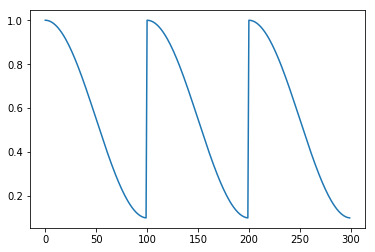

In [8]:
from math import pi, cos


eta_min = 0.1
eta_max = 1
T_max = 100
T_cur = 0


class Cosine:
    def __init__(self, T_max, eta_min, eta_max):
        self.T_max = T_max
        self.eta_min = eta_min
        self.eta_max = eta_max

    def __getitem__(self, T_cur):
        T_cur = T_cur % self.T_max
        eta_t = eta_min + 0.5 * (self.eta_max - self.eta_min) * (1 + cos(T_cur / self.T_max * pi))
        return eta_t

cosine = Cosine(T_max, eta_min, eta_max)

lrs = [cosine[T_cur] for T_cur in range(T_max*3)]
plt.plot(lrs)

In [9]:
model = get_model()

lr_policy = OptimizerPolicy("lr", Cosine(eta_max=0.1, eta_min=0.001, T_max=len(train_dl)))                            
mom_policy = OptimizerPolicy("momentum", Cosine(eta_max=0.0, eta_min=0.06, T_max=len(train_dl)))
# mom_policy = OptimizerPolicy("momentum", Linear(T_max=len(train_dl), eta_max=0.0, eta_min=0.06))

model.fit_generator(
    train_dl,
    val_dl,
    epochs=2,
    callbacks=[
        lr_policy,
        mom_policy,
    ],
);

Epoch 1/2 6.71s Step 196/196: loss: 1.964055, acc: 34.344000, val_loss: 1.519574, val_acc: 44.900000
Epoch 2/2 6.11s Step 196/196: loss: 1.476322, acc: 46.848000, val_loss: 1.347081, val_acc: 51.170000


# Policy setter for different parts of the optimizer
One lr setter, one momentum setter, etc.

```python
steps = len(train_dl)

# this look nice
lr_policy = OptimizerPolicy( "lr", [
    np.linspace(0.001, 0.1, steps),
    Cosine(eta_max=0.1, eta_min=0.001, T_max=steps),
    Cosine(eta_max=0.1, eta_min=0.001, T_max=steps*2),
])
# but it gets cumbersome if you want to set multiple parameters.
# now you have to make sure that the length of momentum matches the lr
mom_policy = OptimizerPolicy("momentum", [
    np.linspace(0, 0, steps),
    Cosine(eta_max=0.0, eta_min=0.06, T_max=3*steps),
])

model = get_model()
model.fit_generator(train_dl, val_dl, epochs=100,
                    callbacks=[lr_policy, mom_policy]);
```

It would be hard to switch between different optimizers.

# Fast.ai-like interface

In [10]:
class Phase:
    """
    A Phase just gives you the parameters for an optimizer at step idx.
    
    The interface is similar to the Dataset class.
    
    TODO generalize to arbitrary parameters not just lr and momentum.
    """
    def __init__(self, steps, *, lr, momentum=None):
        self.steps = steps
        self.current_step = 0
        
        self.lr, self.lr_spec = self._parse_spec(lr, self.steps)        
        self.momentum, self.momentum_spec = self._parse_spec(momentum, self.steps)

    def __len__(self):
        return self.steps
    
    def __getitem__(self, idx):
        result = {}
        if self.lr_spec is not None:
            result["lr"] = self.lr[idx]
        if self.momentum is not None:
            result["momentum"] = self.momentum[idx]
        return result
    
    def __repr__(self):
        return (
            f"Phase: {self.current_step+1}/{self.steps}\n"
            f"    lr: {self.lr_spec}\n"
            f"    momentum: {self.momentum_spec}"
        )
    
    def _parse_spec(self, spec, steps):
        if spec is None:
            return None, None
        
        # clean up spec
        if isinstance(spec, (int, float)):
            spec = (spec, spec, "linear")
        elif isinstance(spec, tuple) and len(spec) == 2:
            spec = (spec[0], spec[1], "linear")
        
        # init from spec
        if isinstance(spec, tuple) and len(spec) == 3:
            start, end, type_ = spec
            if type_ in ("linear", "lin"):
                return np.linspace(start, end, steps), spec
            elif type_ in ("tri", "triangular"):
                values = np.block([np.linspace(start, end, math.floor(steps / 2)),
                                   np.linspace(end, start, math.ceil(steps / 2))])
                return values, spec
            elif type_ in ("cosine", "cos"):
                values = [(start + 0.5 * (end - start) * (1 + cos(i / steps * pi)))
                          for i in range(steps)]
                return values, spec

            else:
                raise ValueError(f"The interpolation type most be either 'lin' or 'cosine' but it is {type_}")
        else:
            raise ValueError(f"Invalid specification '{spec}'")

In [11]:
class OptPolicy(Callback):
    def __init__(self, phases):
        self.phases = phases
        self.phase_iter = self._phase_iter()
        
    def on_batch_begin(self, batch, logs):
        try:
            spec = next(self.phase_iter)
            self._update_optimizer(spec)
        except StopIteration:
            # Don't do anything when we run out of phases
            # TODO there must be a better way
            pass
    
    def _phase_iter(self):
        for phase in phases:
            print()
            print()
            print(phase)
            print()
            for spec in phase:
                yield spec

        self.no_phases_left = True

    def _update_optimizer(self, spec):
        for param_name, param_value in spec.items():
            for group in self.model.optimizer.param_groups:
                group[param_name] = param_value

## Simple linear and cosine policy

In [12]:
# we only specify the first epoch with the phase, but we can fit more epochs.
steps = len(train_dl)
phases = [
    Phase(steps, lr=(0.01, 0.1)),
]

model = get_model()
log = model.fit_generator(train_dl, val_dl, epochs=2,
                          callbacks=[OptPolicy(phases)])

Epoch 1/2

Phase: 1/196
    lr: (0.01, 0.1, 'linear')
    momentum: None

Epoch 1/2 5.92s Step 196/196: loss: 1.994929, acc: 29.372000, val_loss: 1.854821, val_acc: 35.550000
Epoch 2/2 5.88s Step 196/196: loss: 1.548684, acc: 44.120000, val_loss: 1.458954, val_acc: 48.500000


In [13]:
# demo some more specs
steps = len(train_dl)
phases = [
    Phase(steps=steps, lr=0.01),  # fix value
    Phase(steps=steps, lr=(0.01, 0.1)),  # linear interpolation
    Phase(steps=steps, lr=(0.1, 0.01, "lin")),
    Phase(steps=steps, lr=(0.1, 0.01, "tri")),
    Phase(steps=steps, lr=(0.1, 0.01, "cosine")),
]

model = get_model()
log = model.fit_generator(train_dl, val_dl, epochs=5,
                          callbacks=[OptPolicy(phases)])

Epoch 1/5

Phase: 1/196
    lr: (0.01, 0.01, 'linear')
    momentum: None

Epoch 1/5 5.82s Step 196/196: loss: 1.919138, acc: 29.472000, val_loss: 1.641093, val_acc: 39.380000
Epoch 2/5

Phase: 1/196
    lr: (0.01, 0.1, 'linear')
    momentum: None

Epoch 2/5 5.85s Step 196/196: loss: 1.820041, acc: 35.568000, val_loss: 2.001775, val_acc: 33.660000
Epoch 3/5

Phase: 1/196
    lr: (0.1, 0.01, 'lin')
    momentum: None

Epoch 3/5 5.92s Step 196/196: loss: 1.426067, acc: 48.584000, val_loss: 1.133967, val_acc: 59.660000
Epoch 4/5

Phase: 1/196
    lr: (0.1, 0.01, 'tri')
    momentum: None

Epoch 4/5 6.06s Step 196/196: loss: 1.302140, acc: 53.300000, val_loss: 1.582742, val_acc: 48.340000
Epoch 5/5

Phase: 1/196
    lr: (0.1, 0.01, 'cosine')
    momentum: None

Epoch 5/5 5.99s Step 196/196: loss: 1.246583, acc: 55.608000, val_loss: 1.636444, val_acc: 46.580000


## Plot differen interpolations

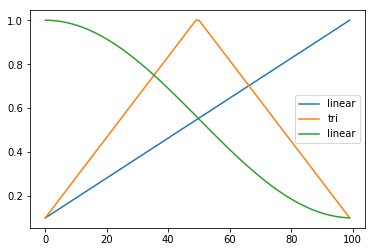

In [17]:
fig, ax = plt.subplots()

phase = Phase(100, lr=(0.1, 1))
ax.plot([step["lr"] for step in phase], label="linear")

phase = Phase(100, lr=(0.1, 1., "tri"))
ax.plot([step["lr"] for step in phase], label="tri")

phase = Phase(100, lr=(0.1, 1., "cos"))
ax.plot([step["lr"] for step in phase], label="linear")

ax.legend()

## SGDR

In [15]:
steps = len(train_dl)

# SGDR with multiplier
cycle_mult = 2
phases = [
    Phase(steps * (cycle_mult**i), lr=(0.1, 0.01, "cos"))
    for i in range(4)
]
# model, loss, optimizer
model = get_model()
log = model.fit_generator(train_dl, val_dl, epochs=15,
                          callbacks=[OptPolicy(phases)])

Epoch 1/15

Phase: 1/196
    lr: (0.1, 0.01, 'cos')
    momentum: None

Epoch 1/15 5.96s Step 196/196: loss: 2.029109, acc: 28.244000, val_loss: 2.141342, val_acc: 30.870000
Epoch 2/15

Phase: 1/392
    lr: (0.1, 0.01, 'cos')
    momentum: None

Epoch 2/15 6.08s Step 196/196: loss: 1.505914, acc: 45.498000, val_loss: 1.537161, val_acc: 45.000000
Epoch 3/15 6.14s Step 196/196: loss: 1.464633, acc: 47.046000, val_loss: 1.543266, val_acc: 45.780000
Epoch 4/15

Phase: 1/784
    lr: (0.1, 0.01, 'cos')
    momentum: None

Epoch 4/15 6.25s Step 196/196: loss: 1.237058, acc: 55.356000, val_loss: 1.104191, val_acc: 59.700000
Epoch 5/15 6.17s Step 196/196: loss: 1.192880, acc: 57.034000, val_loss: 1.290545, val_acc: 54.860000
Epoch 6/15 6.22s Step 196/196: loss: 1.203275, acc: 56.806000, val_loss: 1.584007, val_acc: 48.560000
Epoch 7/15 6.19s Step 196/196: loss: 1.162999, acc: 58.438000, val_loss: 1.440878, val_acc: 51.240000
Epoch 8/15

Phase: 1/1568
    lr: (0.1, 0.01, 'cos')
    momentum: Non

## Specifying multiple parameters

In [16]:
steps = len(train_dl)
phases = [
    # One Cycle policy
    Phase(steps=20*steps, lr=(0.01, 1), momentum=(0.95, 0.85)),
    Phase(steps=20*steps, lr=(1, 0.01), momentum=(0.85, 0.95)),
    Phase(steps=2*steps, lr=(0.01, 0.005), momentum=0.95)
] 
# model, loss, optimizer
model = get_model()
log = model.fit_generator(train_dl, val_dl, epochs=42,
                          callbacks=[OptPolicy(phases)])

Epoch 1/42

Phase: 1/3920
    lr: (0.01, 1, 'linear')
    momentum: (0.95, 0.85, 'linear')

Epoch 1/42 6.20s Step 196/196: loss: 1.911161, acc: 33.548000, val_loss: 2.109537, val_acc: 41.130000
Epoch 2/42 6.29s Step 196/196: loss: 1.766813, acc: 39.910000, val_loss: 1.632113, val_acc: 41.020000
Epoch 3/42 6.23s Step 196/196: loss: 1.469780, acc: 46.796000, val_loss: 1.341495, val_acc: 52.620000
Epoch 4/42 6.24s Step 196/196: loss: 1.270484, acc: 54.488000, val_loss: 1.030468, val_acc: 63.190000
Epoch 5/42 6.23s Step 196/196: loss: 1.142736, acc: 59.470000, val_loss: 1.088933, val_acc: 61.800000
Epoch 6/42 6.28s Step 196/196: loss: 1.054598, acc: 62.648000, val_loss: 0.942151, val_acc: 67.240000
Epoch 7/42 6.35s Step 196/196: loss: 0.976676, acc: 65.580000, val_loss: 0.994445, val_acc: 67.440000
Epoch 8/42 6.28s Step 196/196: loss: 0.925636, acc: 67.608000, val_loss: 0.842978, val_acc: 71.480000
Epoch 9/42 6.27s Step 196/196: loss: 0.885354, acc: 69.272000, val_loss: 0.811209, val_acc: 